# Problem 3: Training and Fine-tuning on Fashion MNIST and MNIST
Training neural networks with a huge number of parameters on a small dataset greatly affects the networks' generalization ability, often resulting in overfitting. Therefore, more often in practice, one would fine-tune existing networks that are trained on a larger dataset by continuing training on a smaller dataset. To get familiar with the fine-tuning procedure, in this problem you need to train a model from scratch on Fashion MNIST dataset and then fine-tune it on MNIST dataset. Note that we are training models on these two toy datasets because of limited computational resources. In most cases, we train models on ImageNet and fine-tune them on smaller datasets.

* <b>Learning Objective:</b> In Problem 2, you implemented a covolutional neural network to perform classification task in TensorFlow. In this part of the assignment, we will show you how to use TensorFlow to fine-tune a trained network on a different task.
* <b>Provided Codes:</b> We provide the the dataset downloading and preprocessing codes, conv2d(), and fc() functions to build the model performing the fine-tuning task.
* <b>TODOs:</b> Train a model from scratch on Fashion MNIST dataset and then fine-tune it on MNIST dataset. Both the training loss and the training accuracy need to be shown.

In [1]:
import numpy as np
import os.path as osp
import os
import subprocess

def download_data(download_root='data/', dataset='mnist'):
    if dataset == 'mnist':
        data_url = 'http://yann.lecun.com/exdb/mnist/'
    elif dataset == 'fashion_mnist':
        data_url = 'http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/'
    else:
        raise ValueError('Please specify mnist or fashion_mnist.')

    data_dir = osp.join(download_root, dataset)
    if osp.exists(data_dir):
        print('The dataset was downloaded.')
        return
    else:
        os.mkdir(data_dir)

    keys = ['train-images-idx3-ubyte.gz', 't10k-images-idx3-ubyte.gz',
            'train-labels-idx1-ubyte.gz', 't10k-labels-idx1-ubyte.gz']

    for k in keys:
        url = (data_url+k).format(**locals())
        target_path = osp.join(data_dir, k)
        cmd = ['curl', url, '-o', target_path]
        print('Downloading ', k)
        subprocess.call(cmd)
        cmd = ['gzip', '-d', target_path]
        print('Unzip ', k)
        subprocess.call(cmd)


def load_data(data_dir):
    num_train = 60000
    num_test = 10000

    def load_file(filename, num, shape):
        fd = open(osp.join(data_dir, filename))
        loaded = np.fromfile(file=fd, dtype=np.uint8)
        return loaded[num:].reshape(shape).astype(np.float)

    train_image = load_file('train-images-idx3-ubyte', 16, (num_train, 28, 28, 1))
    train_label = load_file('train-labels-idx1-ubyte', 8, num_train)
    test_image = load_file('t10k-images-idx3-ubyte', 16, (num_test, 28, 28, 1))
    test_label = load_file('t10k-labels-idx1-ubyte', 8, num_test)
    return train_image, train_label, test_image, test_label

In [2]:
# Download MNIST and Fashion MNIST
download_data(dataset='mnist')
download_data(dataset='fashion_mnist')

The dataset was downloaded.
The dataset was downloaded.


In [3]:
import tensorflow as tf
import tensorflow.contrib.slim as slim
import matplotlib.pyplot as plt

%matplotlib inline

def conv2d(input, output_shape, k=4, s=2, name='conv2d'):
    with tf.variable_scope(name):
        return slim.conv2d(input, output_shape, [k, k], stride=s)


def fc(input, output_shape, act_fn=tf.nn.relu, name='fc'):
    with tf.variable_scope(name):
        return slim.fully_connected(input, output_shape, activation_fn=act_fn)

    
def train(batch_size=100, num_epoch=5, learning_rate=1e-5,
          num_train=60000, num_test=10000):
    
    sess = tf.InteractiveSession()
    
    # Build the model
    X = tf.placeholder(tf.float32, [None, 28, 28, 1])
    Y = tf.placeholder(tf.int64, [None])
    labels = tf.one_hot(Y, 10)
    _ = conv2d(X, 32, name='conv1')
    _ = conv2d(_, 64, name='conv2')
    _ = conv2d(_, 256, name='conv3')
    _ = tf.reshape(_, [-1, np.prod(_.get_shape().as_list()[1:])])
    _ = fc(_, 256, name='fc1')
    logits = fc(_, 10, act_fn=None, name='fc2')

    loss = tf.nn.softmax_cross_entropy_with_logits(labels=labels, logits=logits)
    loss_op = tf.reduce_mean(loss)

    global_step = tf.Variable(0, trainable=False)
    learning_rate = 1e-4
    optimizer = tf.train.AdamOptimizer(learning_rate)
    train_op = optimizer.minimize(loss, global_step=global_step)

    predict = tf.argmax(logits, 1)
    correct = tf.equal(predict, Y)
    accuracy_op = tf.reduce_mean(tf.cast(correct, tf.float32))

    sess.run(tf.global_variables_initializer())

    total_loss = []
    total_accuracy = []
    
    
    print('\033[93mTrain Fashion MNIST\033[0m')
    X_train, Y_train, X_test, Y_test = load_data('data/fashion_mnist')
    #############################################################################
    # TODO: Train the model on Fashion MNIST from scratch                       #
    # and then fine-tune it on MNIST                                            #
    # Collect the training loss and the training accuracy                       #
    # fetched from each iteration                                               #
    # After the two stages of the training, the length of                       #
    # total_loss and total_accuracy shuold be                                   #
    # 2 *num_epoch * num_train / batch_size = 2 * 5 * 60000 / 100 = 6000        #
    #############################################################################
    
    # Train the model on Fashion MNIST
    for epoch in range(num_epoch):
        for i in range(num_train // batch_size):
            X_ = X_train[i * batch_size:(i + 1) * batch_size][:]
            Y_ = Y_train[i * batch_size:(i + 1) * batch_size]

            feed_dict = {X: X_,
                         Y: Y_}

            fetches = [train_op, loss_op, accuracy_op]

            _, loss, accuracy = sess.run(fetches, feed_dict=feed_dict)
            total_loss.append(loss)
            total_accuracy.append(accuracy)

            if i % 50 == 0:
                print('iteration (%d): loss = %.3f, accuracy = %.3f' %(i, loss, accuracy))
            i += 1

        # Graph 1. X: epoch, Y: training loss
        plt.subplot(2, 1, 1)
        plt.title('Training loss')
        plt.plot(total_loss, '-o', label="Training loss")
        plt.xlabel('Iteration')

        # Graph 2. X: epoch, Y: training accuracy
        plt.subplot(2, 1, 2)
        plt.title('Training accuracy')
        plt.plot(total_accuracy, '-o', label="Training accuracy")
        plt.xlabel('Iteration')

        for i in [1, 2]:
            plt.subplot(2, 1, i)
            plt.legend(loc='upper center', ncol=4)
        plt.gcf().set_size_inches(15, 15)
        plt.show()
        
        loss = total_loss[-1]
        accuracy = total_accuracy[-1]
        print('[Epoch {}] loss: {}, accuracy: {}'.format(epoch, loss, accuracy))
    
    saver = tf.train.Saver()
    model_path = saver.save(sess, "lib/tf_models/problem3/mnist_fashion_weight.ckpt")
    print("Model saved in %s" % model_path)
    
    # Train the model on MNIST
    print('\033[93mTrain MNIST\033[0m')
    X_train, Y_train, X_test, Y_test = load_data('data/mnist')
    for epoch in range(num_epoch):
        for i in range(num_train // batch_size):
            X_ = X_train[i * batch_size:(i + 1) * batch_size][:]
            Y_ = Y_train[i * batch_size:(i + 1) * batch_size]

            feed_dict = {X: X_,
                         Y: Y_}

            fetches = [train_op, loss_op, accuracy_op]

            _, loss, accuracy = sess.run(fetches, feed_dict=feed_dict)
            total_loss.append(loss)
            total_accuracy.append(accuracy)

            if i % 50 == 0:
                print('iteration (%d): loss = %.3f, accuracy = %.3f' %(i, loss, accuracy))
            i += 1

        # Graph 1. X: epoch, Y: training loss
        plt.subplot(2, 1, 1)
        plt.title('Training loss')
        plt.plot(total_loss, '-o', label="Training loss")
        plt.xlabel('Iteration')

        # Graph 2. X: epoch, Y: training accuracy
        plt.subplot(2, 1, 2)
        plt.title('Training accuracy')
        plt.plot(total_accuracy, '-o', label="Training accuracy")
        plt.xlabel('Iteration')

        for i in [1, 2]:
            plt.subplot(2, 1, i)
            plt.legend(loc='upper center', ncol=4)
        plt.gcf().set_size_inches(15, 15)
        plt.show()
        
        loss = total_loss[-1]
        accuracy = total_accuracy[-1]
        print('[Epoch {}] loss: {}, accuracy: {}'.format(epoch, loss, accuracy))
    
    saver = tf.train.Saver()
    model_path = saver.save(sess, "lib/tf_models/problem3/mnist_weight.ckpt")
    print("Model saved in %s" % model_path)
    
    sess.close()
    #############################################################################
    #                             END OF YOUR CODE                              #
    #############################################################################
    return total_loss, total_accuracy

Train Fashion MNIST
iteration (0): loss = 7.436, accuracy = 0.120
iteration (50): loss = 0.731, accuracy = 0.690
iteration (100): loss = 0.475, accuracy = 0.800
iteration (150): loss = 0.464, accuracy = 0.850
iteration (200): loss = 0.467, accuracy = 0.820
iteration (250): loss = 0.294, accuracy = 0.910
iteration (300): loss = 0.492, accuracy = 0.780
iteration (350): loss = 0.326, accuracy = 0.870
iteration (400): loss = 0.528, accuracy = 0.850
iteration (450): loss = 0.306, accuracy = 0.880
iteration (500): loss = 0.483, accuracy = 0.830
iteration (550): loss = 0.385, accuracy = 0.830


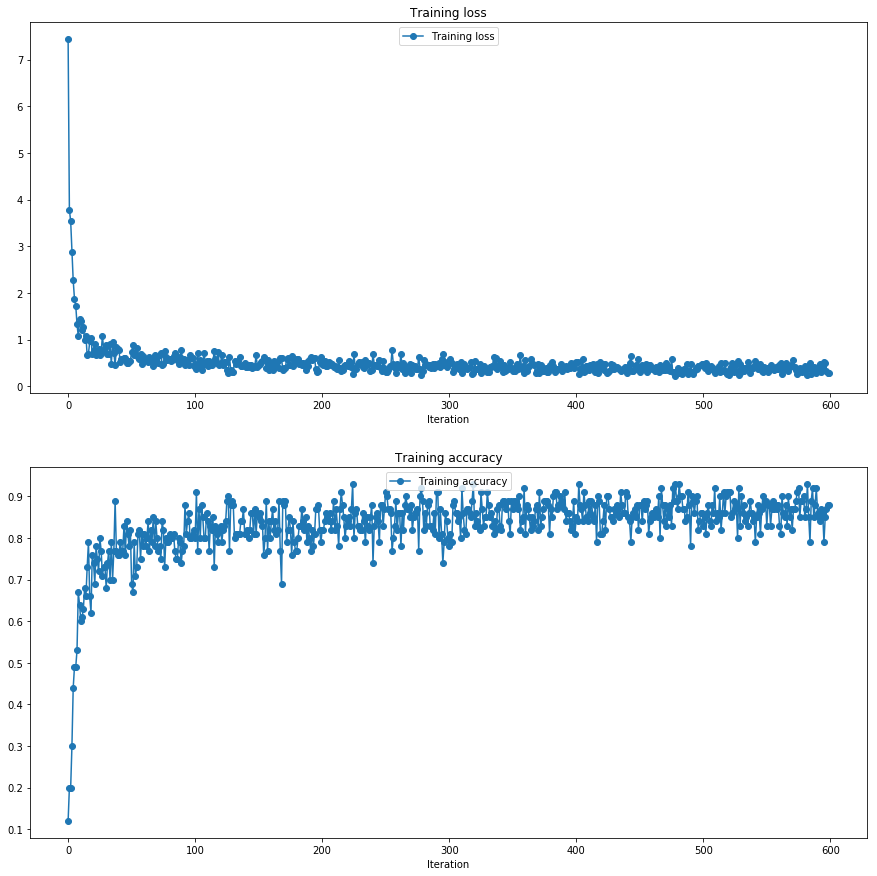

[Epoch 0] loss: 0.285582005978, accuracy: 0.879999995232
iteration (0): loss = 0.206, accuracy = 0.920
iteration (50): loss = 0.370, accuracy = 0.840
iteration (100): loss = 0.291, accuracy = 0.890
iteration (150): loss = 0.337, accuracy = 0.870
iteration (200): loss = 0.311, accuracy = 0.880
iteration (250): loss = 0.212, accuracy = 0.920
iteration (300): loss = 0.308, accuracy = 0.910
iteration (350): loss = 0.275, accuracy = 0.870
iteration (400): loss = 0.489, accuracy = 0.870
iteration (450): loss = 0.236, accuracy = 0.900
iteration (500): loss = 0.369, accuracy = 0.880
iteration (550): loss = 0.310, accuracy = 0.860


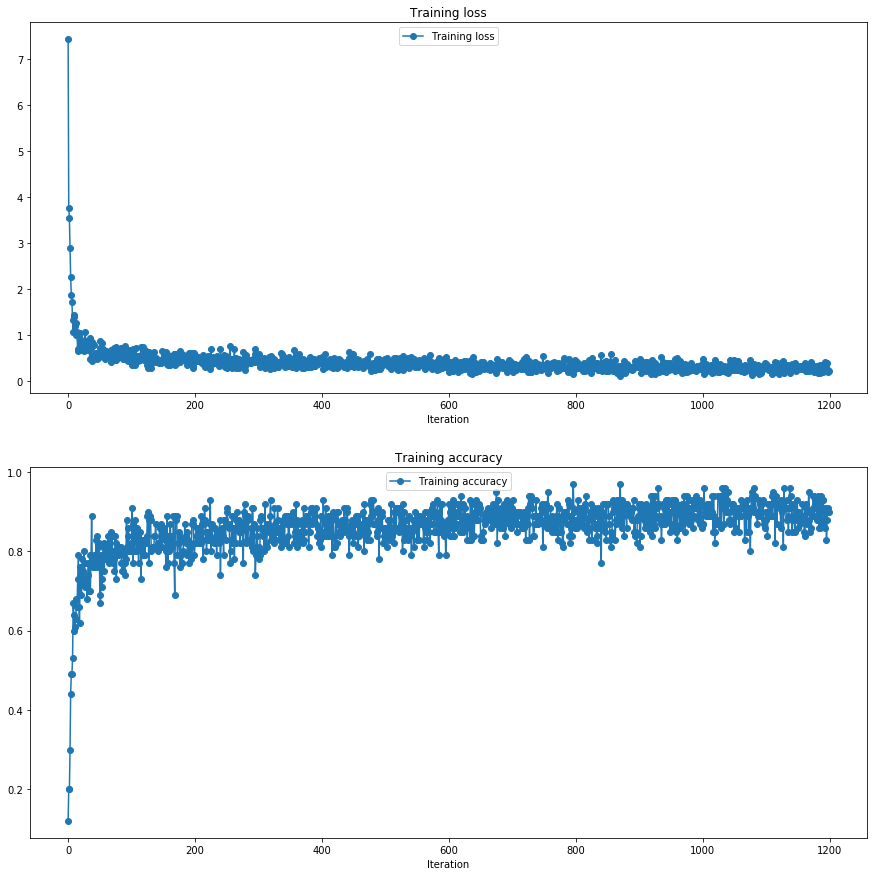

[Epoch 1] loss: 0.22386264801, accuracy: 0.899999976158
iteration (0): loss = 0.164, accuracy = 0.960
iteration (50): loss = 0.319, accuracy = 0.890
iteration (100): loss = 0.226, accuracy = 0.930
iteration (150): loss = 0.254, accuracy = 0.890
iteration (200): loss = 0.250, accuracy = 0.900
iteration (250): loss = 0.194, accuracy = 0.910
iteration (300): loss = 0.237, accuracy = 0.940
iteration (350): loss = 0.234, accuracy = 0.920
iteration (400): loss = 0.381, accuracy = 0.870
iteration (450): loss = 0.180, accuracy = 0.940
iteration (500): loss = 0.271, accuracy = 0.900
iteration (550): loss = 0.260, accuracy = 0.890


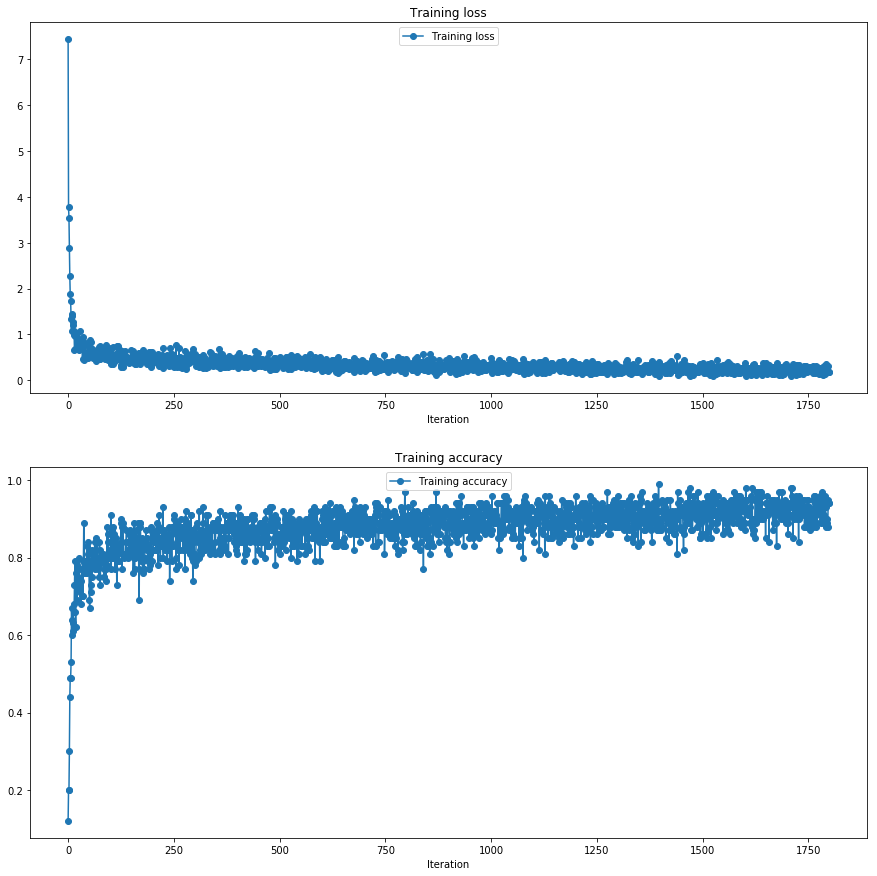

[Epoch 2] loss: 0.190872460604, accuracy: 0.94000005722
iteration (0): loss = 0.140, accuracy = 0.950
iteration (50): loss = 0.230, accuracy = 0.910
iteration (100): loss = 0.192, accuracy = 0.940
iteration (150): loss = 0.200, accuracy = 0.910
iteration (200): loss = 0.217, accuracy = 0.910
iteration (250): loss = 0.190, accuracy = 0.920
iteration (300): loss = 0.179, accuracy = 0.940
iteration (350): loss = 0.178, accuracy = 0.930
iteration (400): loss = 0.275, accuracy = 0.900
iteration (450): loss = 0.147, accuracy = 0.950
iteration (500): loss = 0.231, accuracy = 0.940
iteration (550): loss = 0.194, accuracy = 0.920


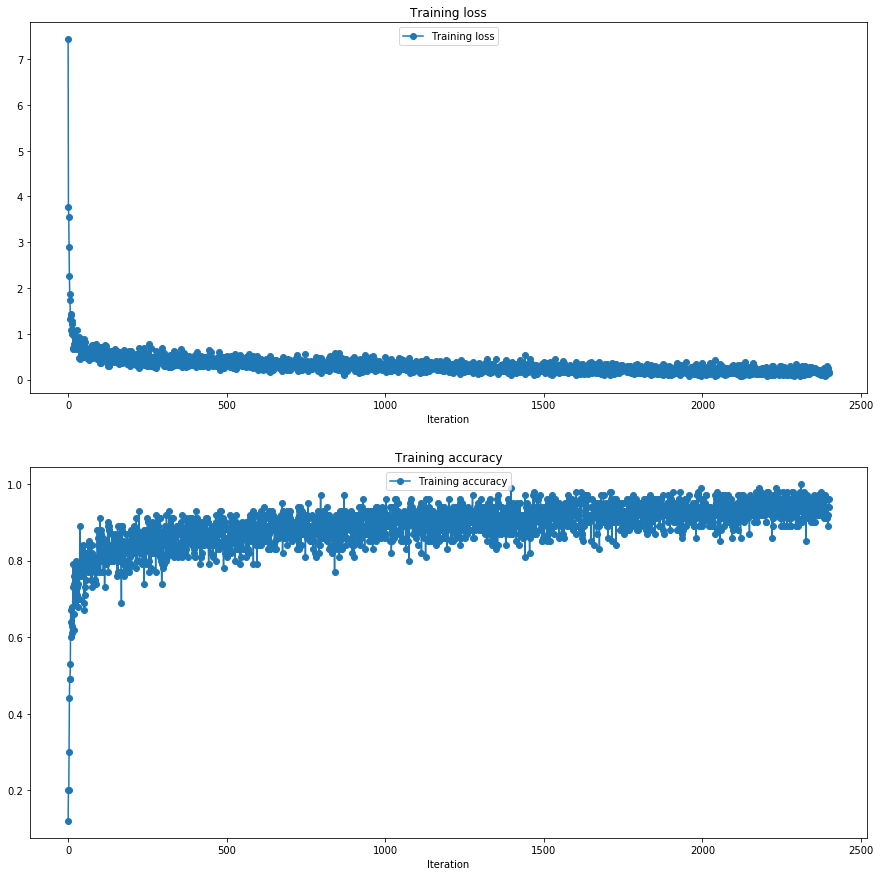

[Epoch 3] loss: 0.154457136989, accuracy: 0.94000005722
iteration (0): loss = 0.114, accuracy = 0.960
iteration (50): loss = 0.182, accuracy = 0.940
iteration (100): loss = 0.132, accuracy = 0.970
iteration (150): loss = 0.178, accuracy = 0.920
iteration (200): loss = 0.170, accuracy = 0.910
iteration (250): loss = 0.165, accuracy = 0.940
iteration (300): loss = 0.145, accuracy = 0.950
iteration (350): loss = 0.156, accuracy = 0.950
iteration (400): loss = 0.214, accuracy = 0.910
iteration (450): loss = 0.135, accuracy = 0.960
iteration (500): loss = 0.190, accuracy = 0.940
iteration (550): loss = 0.146, accuracy = 0.950


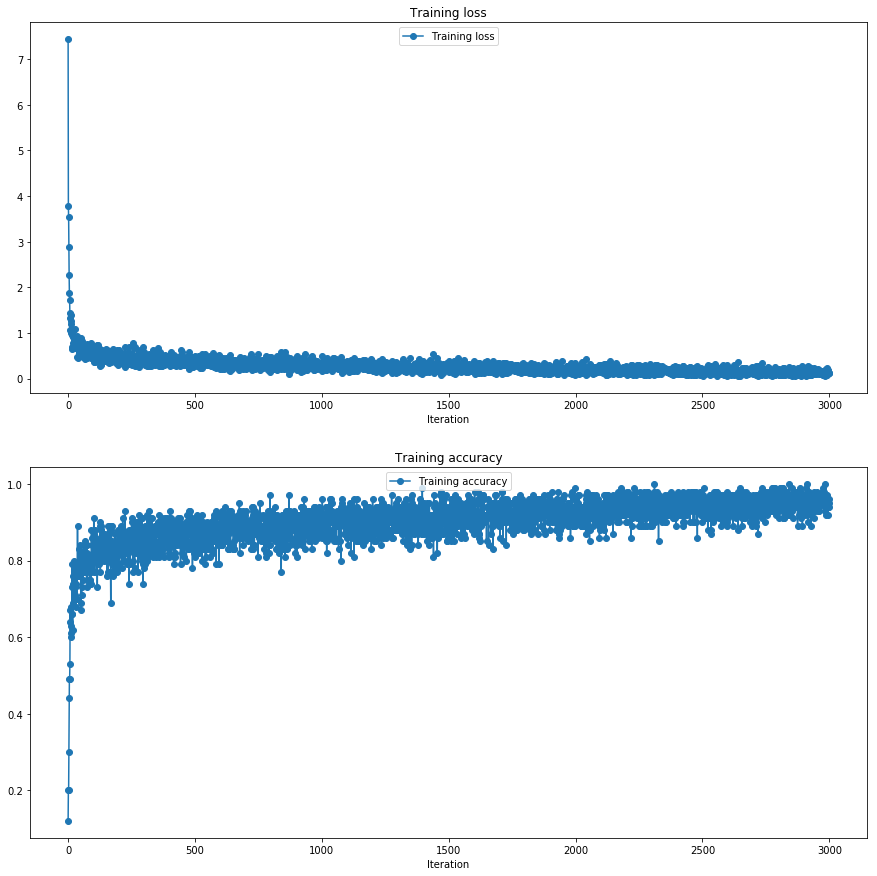

[Epoch 4] loss: 0.130520477891, accuracy: 0.939999997616
Model saved in lib/tf_models/problem3/mnist_fashion_weight.ckpt
Train MNIST
iteration (0): loss = 7.305, accuracy = 0.170
iteration (50): loss = 0.208, accuracy = 0.920
iteration (100): loss = 0.151, accuracy = 0.970
iteration (150): loss = 0.079, accuracy = 0.980
iteration (200): loss = 0.229, accuracy = 0.940
iteration (250): loss = 0.057, accuracy = 0.980
iteration (300): loss = 0.134, accuracy = 0.970
iteration (350): loss = 0.078, accuracy = 0.980
iteration (400): loss = 0.058, accuracy = 0.980
iteration (450): loss = 0.060, accuracy = 0.990
iteration (500): loss = 0.030, accuracy = 1.000
iteration (550): loss = 0.028, accuracy = 0.990


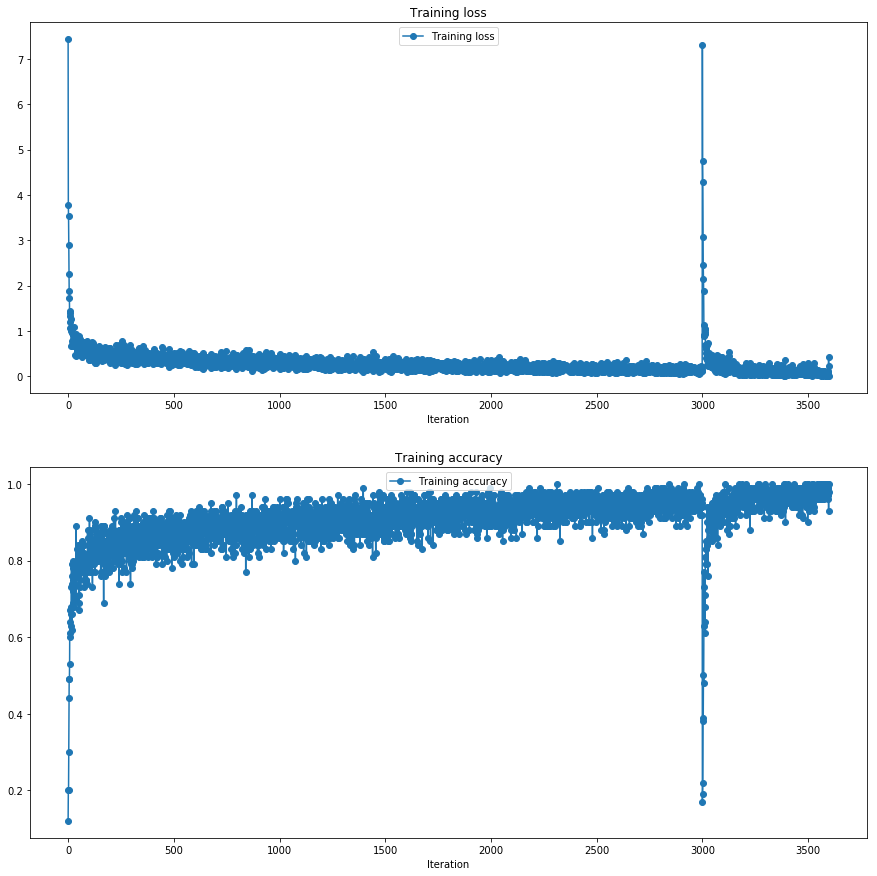

[Epoch 0] loss: 0.227941066027, accuracy: 0.979999959469
iteration (0): loss = 0.084, accuracy = 0.990
iteration (50): loss = 0.055, accuracy = 0.970
iteration (100): loss = 0.026, accuracy = 0.990
iteration (150): loss = 0.012, accuracy = 1.000
iteration (200): loss = 0.076, accuracy = 0.980
iteration (250): loss = 0.015, accuracy = 1.000
iteration (300): loss = 0.067, accuracy = 0.990
iteration (350): loss = 0.025, accuracy = 0.990
iteration (400): loss = 0.016, accuracy = 1.000
iteration (450): loss = 0.021, accuracy = 0.990
iteration (500): loss = 0.014, accuracy = 1.000
iteration (550): loss = 0.004, accuracy = 1.000


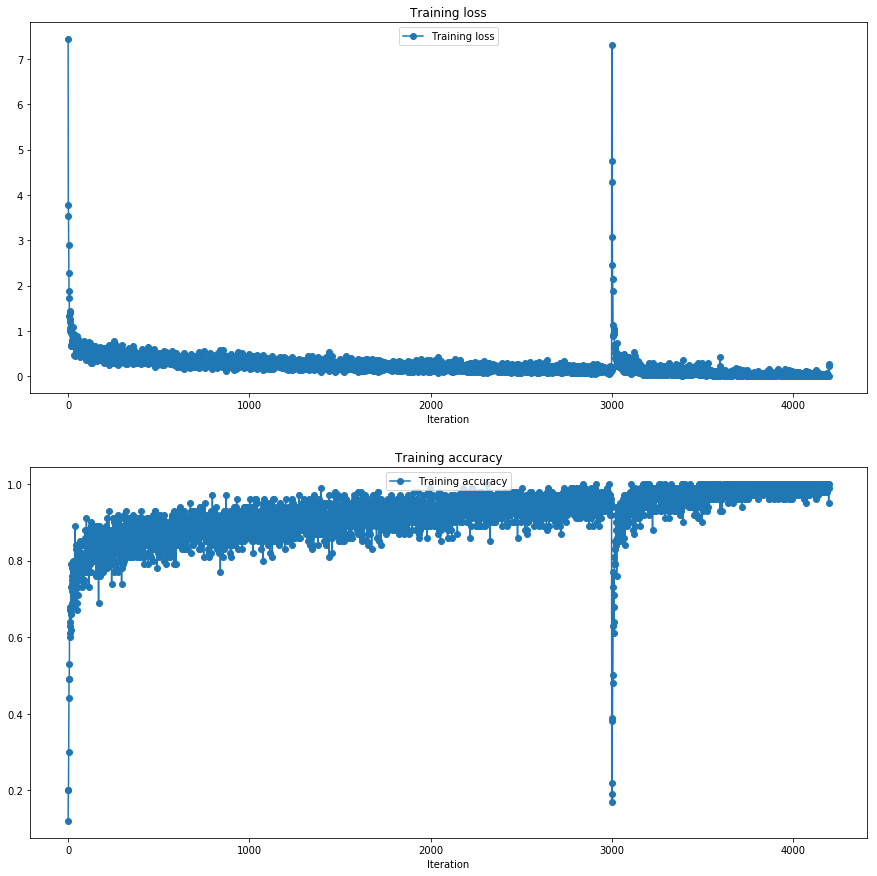

[Epoch 1] loss: 0.215576425195, accuracy: 0.990000009537
iteration (0): loss = 0.043, accuracy = 0.980
iteration (50): loss = 0.017, accuracy = 1.000
iteration (100): loss = 0.012, accuracy = 1.000
iteration (150): loss = 0.011, accuracy = 0.990
iteration (200): loss = 0.029, accuracy = 0.990
iteration (250): loss = 0.005, accuracy = 1.000
iteration (300): loss = 0.026, accuracy = 0.990
iteration (350): loss = 0.014, accuracy = 1.000
iteration (400): loss = 0.010, accuracy = 1.000
iteration (450): loss = 0.007, accuracy = 1.000
iteration (500): loss = 0.004, accuracy = 1.000
iteration (550): loss = 0.001, accuracy = 1.000


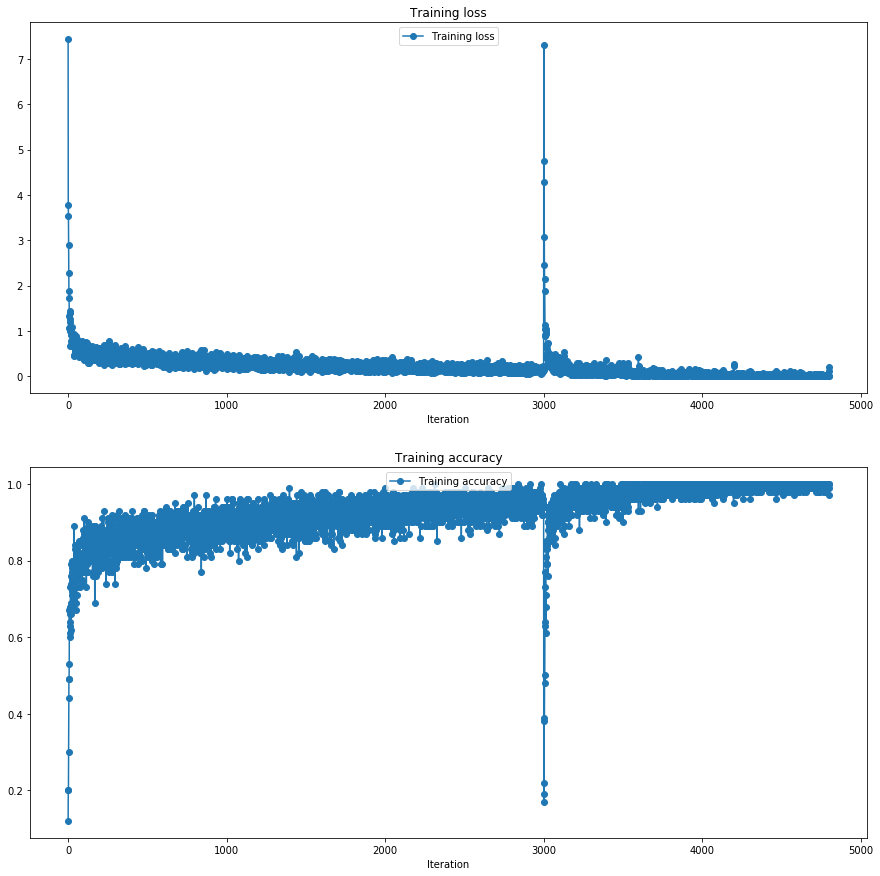

[Epoch 2] loss: 0.200738981366, accuracy: 0.990000009537
iteration (0): loss = 0.013, accuracy = 0.990
iteration (50): loss = 0.010, accuracy = 1.000
iteration (100): loss = 0.008, accuracy = 1.000
iteration (150): loss = 0.004, accuracy = 1.000
iteration (200): loss = 0.008, accuracy = 1.000
iteration (250): loss = 0.002, accuracy = 1.000
iteration (300): loss = 0.004, accuracy = 1.000
iteration (350): loss = 0.003, accuracy = 1.000
iteration (400): loss = 0.003, accuracy = 1.000
iteration (450): loss = 0.003, accuracy = 1.000
iteration (500): loss = 0.002, accuracy = 1.000
iteration (550): loss = 0.000, accuracy = 1.000


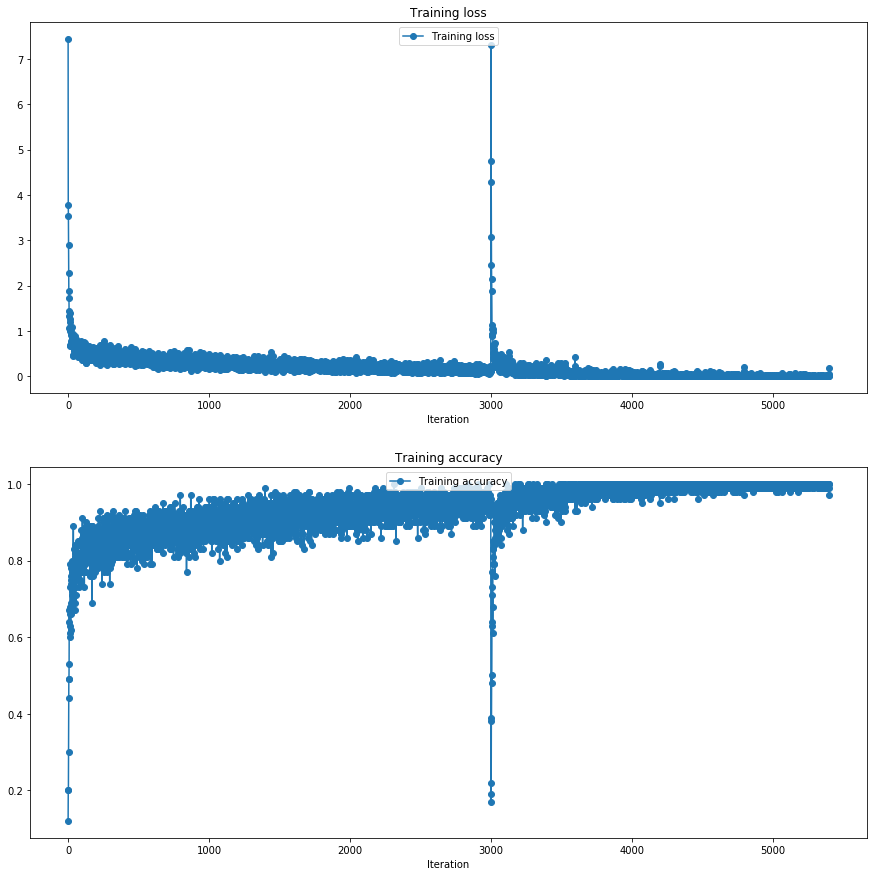

[Epoch 3] loss: 0.184782639146, accuracy: 0.989999949932
iteration (0): loss = 0.002, accuracy = 1.000
iteration (50): loss = 0.007, accuracy = 1.000
iteration (100): loss = 0.010, accuracy = 1.000
iteration (150): loss = 0.001, accuracy = 1.000
iteration (200): loss = 0.006, accuracy = 1.000
iteration (250): loss = 0.000, accuracy = 1.000
iteration (300): loss = 0.008, accuracy = 1.000
iteration (350): loss = 0.001, accuracy = 1.000
iteration (400): loss = 0.000, accuracy = 1.000
iteration (450): loss = 0.002, accuracy = 1.000
iteration (500): loss = 0.003, accuracy = 1.000
iteration (550): loss = 0.002, accuracy = 1.000


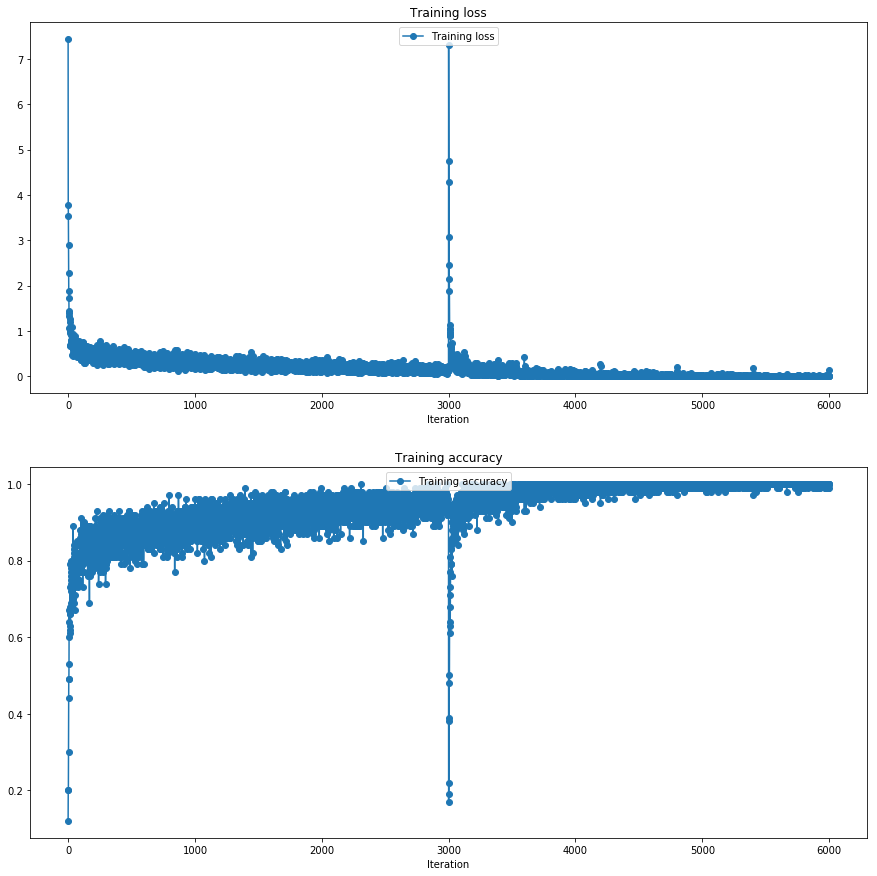

[Epoch 4] loss: 0.134255081415, accuracy: 0.990000009537
Model saved in lib/tf_models/problem3/mnist_weight.ckpt


In [4]:
loss, accuracy = train()

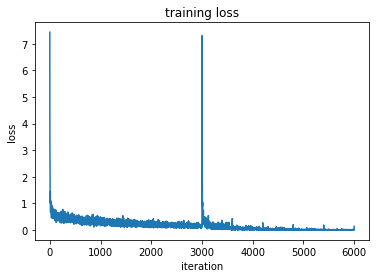

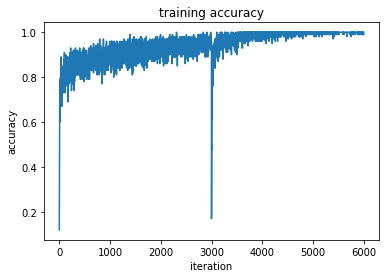

In [5]:
# Plot the training loss and the training accuracy
plt.plot(loss)
plt.title('training loss')
plt.xlabel('iteration')
plt.ylabel('loss')
plt.show()    

plt.plot(accuracy)
plt.title('training accuracy')
plt.xlabel('iteration')
plt.ylabel('accuracy')
plt.show()